# Find the Measured Velocities


In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import os
import sys
from typing import Tuple
from datetime import datetime
from pathlib import Path
from tqdm import tqdm


def recursive_root(path: str, find="sumo-uc-2023"):
    if os.path.split(path)[-1] == find:
        return Path(path)
    return recursive_root(os.path.split(path)[0], find=find)


ROOT = recursive_root(os.path.abspath("."))
sys.path.append(str(ROOT))


## Read the SUMO Configurations


In [3]:
from src.walk_configs import walk_configs
from constants import experiment_path, default_experiment_path


In [4]:
# configs = list(walk_configs(experiment_path))
# default_configs = list(walk_configs(default_experiment_path))


In [5]:
# len(configs)


### Read the File


In [6]:
import pandas as pd


def get_summary_df(
    config, file_name: str, additional_params: dict = None, T: bool = False
) -> pd.DataFrame:
    if additional_params is None:
        additional_params = {}
    df = pd.read_parquet(Path(config.Metadata.cwd) / file_name)
    if T:
        df = df.T
    for key, value in additional_params.items():
        df[key] = value
    return df


def get_fuel(config, **aditional_params) -> float:
    # pandas
    df = pd.read_csv(
        config.Blocks.FuelTotalConfig.output_path, header=None, names=["time", "fuel"]
    )
    for param, value in aditional_params.items():
        df[param] = value
    return df


In [7]:
# import contextlib

# west_thru_dfs = []
# east_thru_dfs = []
# calibration_dfs = []
# headway_dfs = []
# fuel_dfs = []
# for config in tqdm(configs):
#     additional_params = {
#         "num": config.Metadata.run_id,
#         "carFollowingModel": config.Blocks.CFTableConfig.additional_params.carFollowModel,
#         "seed": config.Blocks.SeedConfig.seed,
#         "cf-table": config.Pipeline.pipeline[0].producers[0].config.val,
#     }
#     with contextlib.suppress(FileNotFoundError):
#         df = get_summary_df(
#             config,
#             file_name="Radar137_East_thru_lowess_summary_df.parquet",
#             additional_params=additional_params,
#         )
#         df["method"] = "lowess"
#         df.rename(columns={"start_time": "start", "end_time": "end"}, inplace=True)

#         pwlf_df = get_summary_df(
#             config,
#             file_name="Radar137_East_thru_pwlf_summary_df.parquet",
#             additional_params=additional_params,
#         )
#         pwlf_df["method"] = "pwlf"

#         df = pd.concat([df, pwlf_df])
#         east_thru_dfs.append(df)

#         df = pd.read_parquet(Path(config.Metadata.cwd) / "calibration_df.parquet")
#         df = df.set_index(
#             "box",
#         ).T
#         for key, value in additional_params.items():
#             df[key] = value

#         calibration_dfs.append(df)

#         # get the headway data
#         headway_df = get_summary_df(
#             config,
#             file_name="Radar137_East_thru_headway_df.parquet",
#             additional_params=additional_params,
#         )

#         headway_dfs.append(headway_df)

#         # get the fuel data
#         with open(config.Blocks.FuelTotalConfig.output_path, "r") as f:
#             # split the file into lines
#             energy, cars = f.read().split(",")
#             additional_params["energy"] = float(energy)
#             additional_params["cars"] = int(cars)

#         fuel_df = pd.DataFrame(additional_params, index=[0])
#         fuel_dfs.append(fuel_df)


# east_thru_df = pd.concat(east_thru_dfs)
# calibration_df = pd.concat(calibration_dfs)
# fuel_df = pd.concat(fuel_dfs)
# headway_df = pd.concat(headway_dfs)


In [8]:
# save the data
# east_thru_df.to_parquet(experiment_path / "east_thru_df.parquet")
# calibration_df.to_parquet(experiment_path / "calibration_df.parquet")
# fuel_df.to_parquet(experiment_path / "fuel_df.parquet")
# headway_df.to_parquet(experiment_path / "headway_df.parquet")
headway_df = pd.read_parquet(experiment_path / "headway_df.parquet")
fuel_df = pd.read_parquet(experiment_path / "fuel_df.parquet")
calibration_df = pd.read_parquet(experiment_path / "calibration_df.parquet")
east_thru_df = pd.read_parquet(experiment_path / "east_thru_df.parquet")

In [ ]:
default_headway_df = pd.read_parquet(default_experiment_path / "headway_df.parquet")
default_fuel_df = pd.read_parquet(default_experiment_path / "fuel_df.parquet")
default_calibration_df = pd.read_parquet(default_experiment_path / "calibration_df.parquet")
default_east_thru_df = pd.read_parquet(default_experiment_path / "east_thru_df.parquet")

NameError: name 'pd' is not defined

In [ ]:
default_headway_df["method"] = "default"
default_fuel_df["method"] = "default"
default_calibration_df["method"] = "default"
default_east_thru_df["method"] = "default"

default_headway_df["carFollowingModel"] = default_headway_df["carFollowingModel"] + " - default"
default_fuel_df["carFollowingModel"] = default_fuel_df["carFollowingModel"] + " - default"
default_calibration_df["carFollowingModel"] = default_calibration_df["carFollowingModel"] + " - default"
default_east_thru_df["carFollowingModel"] = default_east_thru_df["carFollowingModel"] + " - default"

In [ ]:
headway_df = pd.concat([headway_df, default_headway_df])
fuel_df = pd.concat([fuel_df, default_fuel_df])

In [107]:
# create a vehicle ~ run id column
headway_df['vehicle_run'] = headway_df['num'].astype(str) + '~' + headway_df['veh'].astype(str)
east_thru_df['vehicle_run'] = east_thru_df['num'].astype(str) + '~' + east_thru_df['vehicle_id'].astype(str)

### Get the Fuel Consumption


In [10]:
SUMO_GASOLINE_GRAM_TO_JOULE: float = 43.4e-3
GRAM_TO_CM3: float = 0.7489
CM3_TO_LITER: float = 0.001


fuel_df["volume_L"] = (
    fuel_df["energy"] / (SUMO_GASOLINE_GRAM_TO_JOULE) * GRAM_TO_CM3 * CM3_TO_LITER
)
fuel_df["volume_L_per_vehicle"] = fuel_df["volume_L"] / fuel_df["cars"]


## Read the RW Data


In [11]:
# lowess_rw_df = pd.read_parquet(ROOT / Path("data/2023-01-13/lowess_method.parquet"))
# lowess_rw_df["method"] = "lowess"
# lowess_rw_df["method"] = "pwlf"
# lowess_rw_df["carFollowingModel"] = "Real World"
# lowess_rw_df["num"] = 0

pwlf_rw_df = pd.read_parquet(ROOT / Path("data/2023-01-13/pwlf_method.parquet"))
pwlf_rw_df["method"] = "pwlf"
pwlf_rw_df["carFollowingModel"] = "Real World"
pwlf_rw_df["num"] = 0
pwlf_rw_df["cf-table"] = "Real World"

headway_rw_df = pd.read_parquet(ROOT / Path("data/2023-01-13/headway.parquet"))
headway_rw_df["carFollowingModel"] = "Real World"
headway_rw_df["num"] = 0
headway_rw_df["cf-table"] = "Real World"


## Process the Data


In [12]:
import numpy as np


def label_types(
    df,
    cruise_thresh_accel: float,
):
    df["type"] = np.where(df["accel"] > cruise_thresh_accel, "accel", "")
    df["type"] = np.where(df["accel"] < -cruise_thresh_accel, "decel", df["type"])
    df["type"] = np.where(
        df["accel"].abs() <= cruise_thresh_accel, "cruise", df["type"]
    )
    return df


def get_vehicle_averages(
    df: pd.DataFrame, groupby_cols=None, descript_cols=None, weight_average_col="accel"
) -> pd.DataFrame:
    if groupby_cols is None:
        groupby_cols = ["num", "method", "vehicle_id"]
    if descript_cols is None:
        descript_cols = [
            "carFollowingModel",
            "cf-table",
            "seed",
        ]
    grouper = df.groupby(groupby_cols)
    grouped_df = grouper[descript_cols].first()
    grouped_df[weight_average_col] = grouper.apply(
        lambda x: np.average(x[weight_average_col], weights=x["time_diff"])
    )
    return grouped_df.reset_index()


## Plot the Histograms


In [13]:
table = "corr_pwlf_product"
# read in the rw data
rw_df = pd.read_csv(
    ROOT / Path(f"data/2023-01-13/processed/{table}.csv"),
)


### Make SUMO Table Similar to RW


In [46]:
import polars as pl

# create an product sample
minium_time_in_state = 1
r2 = 0.95


def get_product_sample(
    df,
    headway_df
):
    # get the product sample
    pwlf_data_keep = df.loc[
        (df.time_diff > minium_time_in_state)
        & (df.r2 > r2)
        & df.type.isin(["accel", "decel"])
    ].copy()
    
    # keep vehicles that have both accel and decel
    pwlf_data_keep = pwlf_data_keep.groupby("vehicle_run").filter(
        lambda x: x.type.nunique() == 2
    )

    res = []
    for v_id, v_df in pwlf_data_keep.groupby("vehicle_run"):
        accels = v_df[v_df.type == "accel"].accel.values
        decels = v_df[v_df.type == "decel"].accel.values
        for accel in accels:
            res.extend(
                {"vehicle_run": v_id, "num": v_id.split("~")[0], "accel": accel, "decel": decel} for decel in decels
            )
    # create a dataframe
    pwlf_df_product = pd.DataFrame(res)

    # merge in the headway data
    pwlf_df_product = pwlf_df_product.merge(
        headway_df[["num", "veh", "mean", "vehicle_run"]].rename(
            columns={"veh": "vehicle_id", "mean": "headway"}
        ), on=["vehicle_run"]
    )

    return pwlf_df_product



def get_average_speed(
    df,
    headway_df,
):
    
    sumo_df_pl = pl.DataFrame(df)
    keep_ids = sumo_df_pl.groupby(
        "vehicle_run"
    ).agg([
        pl.col('accel').abs().max().alias('max_accel'),

    ]).filter(
        (pl.col('max_accel') < 1)
        & (~pl.col('vehicle_run').is_in(headway_df['vehicle_run'].unique().tolist()))
    ).select(
        pl.col('vehicle_run')
    ).to_pandas().values.flatten().tolist()

    return sumo_df_pl.filter(
        pl.col('vehicle_run').is_in(keep_ids)
        & pl.col('type').is_in(['cruise'])
    ).to_pandas()

In [65]:
import seaborn as sns
import numpy as np


def create_ecdf(
    plot_df,
    ax,
    color_map,
    x_lims,
    plot_col,
    xlabel,
    ylabel=None,
    show_legend=False,
):
    labels = []
    for i, model in enumerate(plot_df["carFollowingModel"].unique()):
        labels += [model]
        # add the mean
        model_df = plot_df[plot_df["carFollowingModel"] == model].copy()

        sorted_x = np.sort(model_df[plot_col].values)
        yvals = np.linspace(0, 1, model_df[plot_col].values.shape[0])

        if model != "Real World":
            # only keep 1/10 of the data
            sorted_x = sorted_x[::100]
            yvals = yvals[::100]

        sns.lineplot(
            # don't use 
            x=sorted_x,
            y=yvals,
            ax=ax,
            color=color_map[model],
            alpha=1,
            linewidth=3,
            legend=bool(show_legend),
            label=model,
        )

        # add a vertical line at the median
        median = np.median(model_df[plot_col].values)
        ax.axvline(median, color=color_map[model], linestyle="--", alpha=1, linewidth=1)

        if model == "Real World":
            continue

        for _, seed_df in model_df.groupby("num"):
                
            sorted_x = np.sort(seed_df[plot_col].values)
            yvals = np.linspace(0, 1, seed_df[plot_col].values.shape[0])

            # only keep 1/10 of the data
            sorted_x = sorted_x[::10]
            yvals = yvals[::10]

            sns.lineplot(
                x=sorted_x,
                y=yvals,
                ax=ax,
                color=color_map[model],
                alpha=0.2,
                linewidth=1,
                legend=False,
            )

    # # remove the legend
    # if not show_legend:
    #     ax.legend_.remove()
    ax.set_xlabel(xlabel)
    # set the x and y axis limits
    ax.set_xlim(*x_lims)


In [66]:
import matplotlib.pyplot as plt
import scienceplots
import seaborn as sns

plt.style.use("science")
# make the text bigger
plt.rcParams.update({"font.size": 16})
palette = sns.color_palette(
    "Paired",
    8,
)
colors = [palette[i] for i in range(0, len(palette), 2)]

# # do the pwlf method
table = "corr_pwlf_product"
# read in the rw data
rw_df = pd.read_csv(
    ROOT / Path(f"data/2023-01-13/processed/{table}.csv"),
)
rw_df['carFollowingModel'] = 'Real World'
rw_df = rw_df.rename(columns={'tau': 'headway'})

# get the pwlf data
sumo_df_raw = east_thru_df[
    (east_thru_df["method"] == "pwlf") & (east_thru_df["cf-table"] == table)
].copy()
sumo_df_raw = label_types(sumo_df_raw, cruise_thresh_accel=0.1)

cf_models = east_thru_df["carFollowingModel"].unique()
cf_models.sort()

# get the product sample
sumo_df = get_product_sample(
    sumo_df_raw.copy(),
    headway_df
)

# merge in the carFollowingModel
sumo_df = sumo_df.merge(
    east_thru_df[["num", "vehicle_run", "carFollowingModel"]].drop_duplicates(),
    on=["vehicle_run"],
)

colors = {
    "Real World": "black",
    **dict(zip(cf_models, colors)),
}


IDM
Krauss
EIDM
Real World
IDM
Krauss
EIDM
Real World
IDM
Krauss
EIDM
Real World
IDM
Krauss
EIDM
Real World


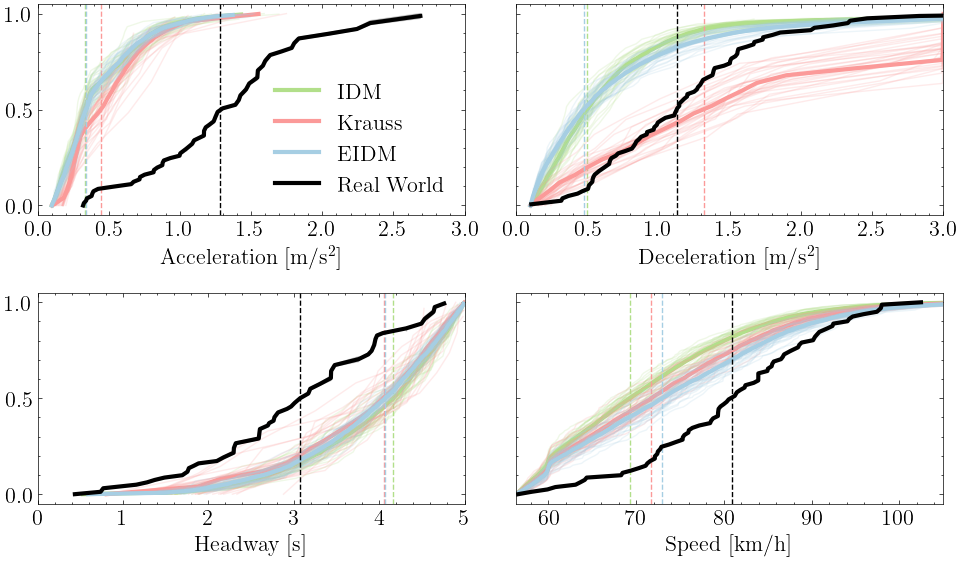

In [68]:
fig, ax = plt.subplots(
    figsize=(10, 6), nrows=2, ncols=2, sharey=True, tight_layout=True
)


accel_averages = pd.concat([
    sumo_df,
    rw_df
])

create_ecdf(
    accel_averages,
    ax[0, 0],
    color_map=colors,
    x_lims=(0, 3),
    plot_col="accel",
    xlabel="Acceleration [m/s$^2$]",
    show_legend=True,
)

# plot the deceleration
accel_averages['decel'] = accel_averages['decel'].abs()
create_ecdf(
    accel_averages,
    ax[0, 1],
    color_map=colors,
    x_lims=(0, 3),
    plot_col="decel",
    xlabel="Deceleration [m/s$^2$]",
    show_legend=False,
)

# plot the headway
create_ecdf(
    accel_averages,
    ax[1, 0],
    color_map=colors,
    x_lims=(0, 5),
    plot_col="headway",
    xlabel="Headway [s]",
    show_legend=False,
)

# only vehicles faster than
sumo_avg = get_average_speed(sumo_df_raw, headway_df)[['speed', 'num', 'vehicle_run', 'carFollowingModel']]
rw_avg = rw_df[['speedFactor']].copy()
rw_avg['speedFactor'] = rw_avg.speedFactor * 22.35
rw_avg = rw_avg.rename(columns={'speedFactor': 'speed'})
rw_avg['carFollowingModel'] = 'Real World'


# convert both to kp/h
sumo_avg['speed'] = sumo_avg['speed'] * 3.6
rw_avg['speed'] = rw_avg['speed'] * 3.6

# limit both to > 35 km/h
sumo_avg = sumo_avg[(sumo_avg['speed'] > (35 * 1.60934))]

cruise_averages = pd.concat([
    sumo_avg,
    rw_avg
])

create_ecdf(
    cruise_averages,
    ax[1, 1],
    color_map=colors,
    x_lims=(35 * 1.60934, 105),
    plot_col="speed",
    xlabel="Speed [km/h]",
    show_legend=False,
)


### Uncorrelated Samples

In [108]:
import matplotlib.pyplot as plt
import scienceplots
import seaborn as sns

plt.style.use("science")
# make the text bigger
plt.rcParams.update({"font.size": 16})
palette = sns.color_palette(
    "Paired",
    8,
)
colors = [palette[i] for i in range(0, len(palette), 2)]

# # do the pwlf method
table = "uncor_pwlf"
# read in the rw data
rw_df = pd.read_csv(
    ROOT / Path(f"data/2023-01-13/processed/{table}.csv"),
)
rw_df['carFollowingModel'] = 'Real World'
rw_df = rw_df.rename(columns={'tau': 'headway'})

# get the pwlf data
sumo_df_raw = east_thru_df[
    (east_thru_df["method"] == "pwlf") & (east_thru_df["cf-table"] == table)
].copy()
sumo_df_raw = label_types(sumo_df_raw, cruise_thresh_accel=0.1)

cf_models = east_thru_df["carFollowingModel"].unique()
cf_models.sort()

colors = {
    "Real World": "black",
    **dict(zip(cf_models, colors)),
}


IDM
Krauss
EIDM
Real World
IDM
Krauss
EIDM
Real World
IDM
Krauss
EIDM
Real World
IDM
Krauss
EIDM
Real World


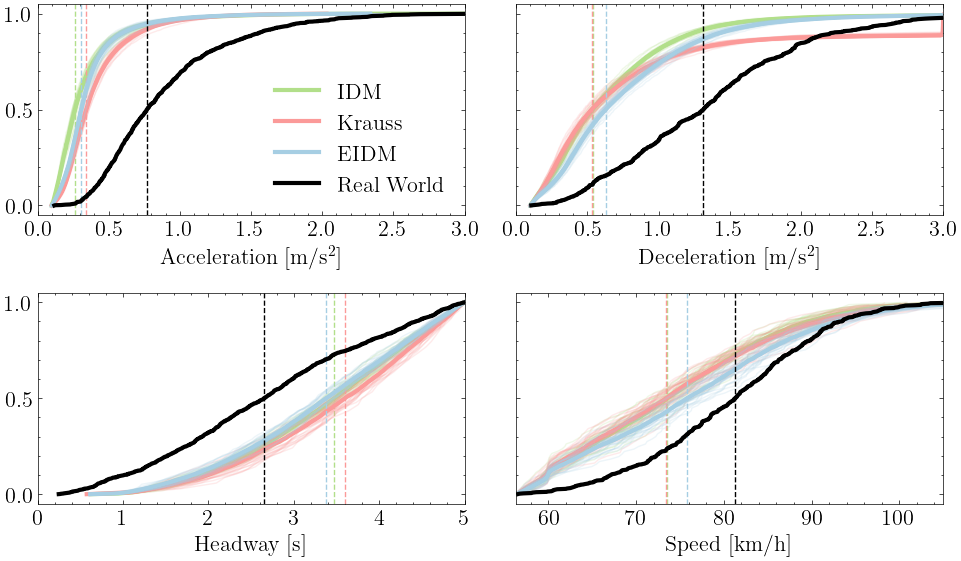

In [111]:
# create an product sample
minium_time_in_state = 1
r2 = 0.95

fig, ax = plt.subplots(
    figsize=(10, 6), nrows=2, ncols=2, sharey=True, tight_layout=True
)

sumo_accels = sumo_df_raw.loc[
    (sumo_df_raw.type == 'accel')
    & (sumo_df_raw['time_diff'] > minium_time_in_state)
    & (sumo_df_raw['r2'] > r2),
    ['accel', 'num', 'vehicle_run', 'carFollowingModel']
]

accel_averages = pd.concat([
    sumo_accels,
    rw_df
])

create_ecdf(
    accel_averages,
    ax[0, 0],
    color_map=colors,
    x_lims=(0, 3),
    plot_col="accel",
    xlabel="Acceleration [m/s$^2$]",
    show_legend=True,
)

# plot the deceleration
sumo_accels = sumo_df_raw.loc[
    (sumo_df_raw.type == 'decel')
    & (sumo_df_raw['time_diff'] > minium_time_in_state)
    & (sumo_df_raw['r2'] > r2),
    ['accel', 'num', 'vehicle_run', 'carFollowingModel']
]

sumo_accels['decel'] = sumo_accels['accel'].abs()
accel_averages = pd.concat([
    sumo_accels,
    rw_df
])
create_ecdf(
    accel_averages,
    ax[0, 1],
    color_map=colors,
    x_lims=(0, 3),
    plot_col="decel",
    xlabel="Deceleration [m/s$^2$]",
    show_legend=False,
)

headways = headway_df[['num', 'vehicle_run', 'mean']].loc[
    headway_df.vehicle_run.isin(sumo_df_raw.vehicle_run.unique())
].rename(columns={'mean': 'headway'})
headways = headways.merge(
    sumo_df_raw[['vehicle_run', 'carFollowingModel']].groupby('vehicle_run').first().reset_index(),
    on=['vehicle_run'],
    how='left'
)
rw_headways = rw_df[['headway', 'carFollowingModel']].copy()
headway_plot_df = pd.concat(
    [
        headways,
        rw_headways

    ]
)

# plot the headway
create_ecdf(
    headway_plot_df,
    ax[1, 0],
    color_map=colors,
    x_lims=(0, 5),
    plot_col="headway",
    xlabel="Headway [s]",
    show_legend=False,
)

# only vehicles faster than
sumo_avg = get_average_speed(sumo_df_raw, headway_df)[['speed', 'num', 'vehicle_run', 'carFollowingModel']]
rw_avg = rw_df[['speedFactor']].copy()
rw_avg['speedFactor'] = rw_avg.speedFactor * 22.35
rw_avg = rw_avg.rename(columns={'speedFactor': 'speed'})
rw_avg['carFollowingModel'] = 'Real World'


# convert both to kp/h
sumo_avg['speed'] = sumo_avg['speed'] * 3.6
rw_avg['speed'] = rw_avg['speed'] * 3.6

# limit both to > 35 km/h
sumo_avg = sumo_avg[(sumo_avg['speed'] > (35 * 1.60934))]

cruise_averages = pd.concat([
    sumo_avg,
    rw_avg
])

create_ecdf(
    cruise_averages,
    ax[1, 1],
    color_map=colors,
    x_lims=(35 * 1.60934, 105),
    plot_col="speed",
    xlabel="Speed [km/h]",
    show_legend=False,
)


In [52]:
rw_df['speedFactor']

0     1.101099
1     0.850802
2     0.863274
3     1.129559
4     1.088923
        ...   
77    0.790750
78    1.176882
79    1.077807
80    1.192483
81    1.211150
Name: speedFactor, Length: 82, dtype: float64

In [48]:
sumo_avg.head()

,vehicle_id,start,end,accel,time_diff,speed,r2,mse,num,carFollowingModel,seed,cf-table,method,vehicle_run,type
0,00_0.0,0.018109,2.399420,-1.491915e-15,2.381312,20.250000,0.000000,4.719446e-29,100,IDM,692,corr_pwlf_product,pwlf,100~00_0.0,cruise
1,00_0.0,2.399420,5.931037,-8.047791e-15,3.531616,20.250000,0.000000,1.823145e-28,100,IDM,692,corr_pwlf_product,pwlf,100~00_0.0,cruise
2,00_0.0,6.108556,6.800000,-1.541433e-14,0.691444,20.250000,0.000000,9.508403e-28,100,IDM,692,corr_pwlf_product,pwlf,100~00_0.0,cruise
3,00_0.1,0.000000,0.600000,-2.800204e-02,0.600000,22.452905,0.642701,7.939987e-06,100,IDM,692,corr_pwlf_product,pwlf,100~00_0.1,cruise
4,00_0.1,0.600000,2.296680,-1.839659e-02,1.696681,22.428387,0.901622,8.374046e-06,100,IDM,692,corr_pwlf_product,pwlf,100~00_0.1,cruise


In [41]:
sumo_df_pl = pl.DataFrame(sumo_df_raw)
keep_ids = sumo_df_pl.groupby(
    "vehicle_run"
).agg([
    pl.col('accel').abs().max().alias('max_accel'),

]).filter(
    (pl.col('max_accel') < 1)
    & (~pl.col('vehicle_run').is_in(headway_df['vehicle_run'].unique().tolist()))
).select(
    pl.col('vehicle_run')
).to_pandas().values.flatten().tolist()

sumo_df_pl.filter(
    pl.col('vehicle_run').is_in(keep_ids)
    & pl.col('type').is_in(['cruise'])
).to_pandas()

,vehicle_id,start,end,accel,time_diff,speed,r2,mse,num,carFollowingModel,seed,cf-table,method,vehicle_run,type
0,00_0.0,0.018109,2.399420,-1.491915e-15,2.381312,20.250000,0.000000,4.719446e-29,100,IDM,692,corr_pwlf_product,pwlf,100~00_0.0,cruise
1,00_0.0,2.399420,5.931037,-8.047791e-15,3.531616,20.250000,0.000000,1.823145e-28,100,IDM,692,corr_pwlf_product,pwlf,100~00_0.0,cruise
2,00_0.0,6.108556,6.800000,-1.541433e-14,0.691444,20.250000,0.000000,9.508403e-28,100,IDM,692,corr_pwlf_product,pwlf,100~00_0.0,cruise
3,00_0.1,0.000000,0.600000,-2.800204e-02,0.600000,22.452905,0.642701,7.939987e-06,100,IDM,692,corr_pwlf_product,pwlf,100~00_0.1,cruise
4,00_0.1,0.600000,2.296680,-1.839659e-02,1.696681,22.428387,0.901622,8.374046e-06,100,IDM,692,corr_pwlf_product,pwlf,100~00_0.1,cruise
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
312308,09600_1.9,77.878244,86.923736,1.104764e-02,9.045491,0.049561,0.955539,3.917549e-05,99,IDM,104,corr_pwlf_product,pwlf,99~09600_1.9,cruise
312309,09600_1.9,86.923736,101.128003,2.998787e-02,14.204267,0.313239,0.998358,2.485205e-05,99,IDM,104,corr_pwlf_product,pwlf,99~09600_1.9,cruise
312310,09600_1.9,101.128003,106.400000,1.397354e-02,5.271997,0.562132,0.960226,1.875719e-05,99,IDM,104,corr_pwlf_product,pwlf,99~09600_1.9,cruise
312311,09600_6.0,10.435332,11.575635,8.090908e-02,1.140302,4.878182,0.265094,1.814793e-03,99,IDM,104,corr_pwlf_product,pwlf,99~09600_6.0,cruise


In [20]:
import polars as pl

sumo_df_pl = pl.from_pandas(sumo_df_raw)

In [36]:
sumo_df_pl.groupby(
    "vehicle_run"
).agg([
    pl.col('accel').abs().max().alias('max_accel'),

]).filter(
    (pl.col('max_accel') < 1)
    & (~pl.col('vehicle_run').is_in(headway_df['vehicle_run'].unique().tolist()))
).select(
        pl.col('vehicle_run')
    ).to_pandas().values.flatten().tolist()

['127~03000_0.26',
 '166~00_0.3',
 '127~06600_1.18',
 '91~014400_0.110',
 '93~017400_7.1',
 '118~04200_0.46',
 '93~015600_0.14',
 '96~012000_1.5',
 '104~04800_0.6',
 '110~016800_0.88',
 '175~014400_1.0',
 '160~013800_0.120',
 '159~06600_0.51',
 '153~07800_0.38',
 '175~019200_0.117',
 '116~06000_0.25',
 '123~010800_0.9',
 '126~011400_0.57',
 '144~09600_0.39',
 '140~06000_0.29',
 '146~012600_0.33',
 '152~012000_0.55',
 '107~0600_0.11',
 '144~06000_0.31',
 '143~09600_0.64',
 '157~018600_0.116',
 '107~015000_0.85',
 '130~012600_0.68',
 '111~018000_0.85',
 '141~03600_0.4',
 '167~019800_0.22',
 '169~07800_1.8',
 '171~021600_0.93',
 '116~07800_0.36',
 '176~09600_1.10',
 '95~06000_17.1',
 '131~01800_0.40',
 '117~06600_1.17',
 '129~015000_0.15',
 '158~01800_0.10',
 '93~06000_1.21',
 '99~012000_0.14',
 '110~09600_0.29',
 '154~010200_0.86',
 '165~04200_0.20',
 '174~05400_0.21',
 '176~013800_1.3',
 '178~013800_0.43',
 '172~00_0.4',
 '148~08400_1.9',
 '123~08400_0.82',
 '150~014400_1.6',
 '152~0900

Real World
IDM
Krauss
EIDM
Real World
IDM
Krauss
EIDM
IDM
Krauss
EIDM
Real World
Real World
IDM
Krauss
EIDM


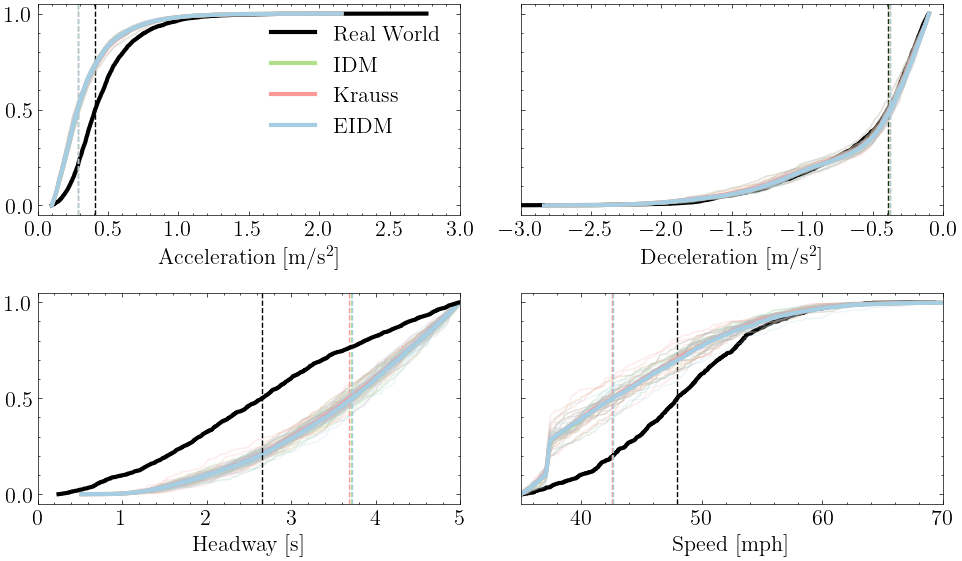

In [16]:
import matplotlib.pyplot as plt
import scienceplots
import seaborn as sns

plt.style.use("science")
# make the text bigger
plt.rcParams.update({"font.size": 16})
palette = sns.color_palette(
    "Paired",
    8,
)
colors = [palette[i] for i in range(0, len(palette), 2)]


# # do the pwlf method
sumo_df = east_thru_df[
    (east_thru_df["method"] == "lowess") & (east_thru_df["cf-table"] == "corr_pwlf")
].copy()
sumo_df = label_types(sumo_df, cruise_thresh_accel=0.1)
cf_models = east_thru_df["carFollowingModel"].unique()
cf_models.sort()

rw_df = lowess_rw_df.copy()
rw_df = label_types(rw_df, cruise_thresh_accel=0.1)


colors = {
    "Real World": "black",
    **dict(zip(cf_models, colors)),
}


fig, ax = plt.subplots(
    figsize=(10, 6), nrows=2, ncols=2, sharey=True, tight_layout=True
)


# plot the acceleration
plot_sumo_df = sumo_df.loc[
    (sumo_df["r2"] > 0.9) & (sumo_df["type"] == "accel") & (sumo_df["time_diff"] > 1)
].copy()

plot_rw_df = rw_df.loc[
    (rw_df["r2"] > 0.9) & (rw_df["type"] == "accel") & (rw_df["time_diff"] > 1)
].copy()
# concat the real world data
plot_sumo_df = pd.concat([plot_sumo_df, plot_rw_df])
accel_averages = get_vehicle_averages(
    plot_sumo_df,
)
create_ecdf(
    accel_averages,
    ax[0, 0],
    color_map=colors,
    x_lims=(0, 3),
    plot_col="accel",
    xlabel="Acceleration [m/s$^2$]",
    show_legend=True,
)

# plot the deceleration
plot_sumo_df = sumo_df.loc[
    (sumo_df["r2"] > 0.9) & (sumo_df["type"] == "decel") & (sumo_df["time_diff"] > 1)
].copy()

plot_rw_df = rw_df.loc[
    (rw_df["r2"] > 0.9) & (rw_df["type"] == "decel") & (rw_df["time_diff"] > 1)
].copy()
# concat the real world data
plot_sumo_df = pd.concat([plot_sumo_df, plot_rw_df])
accel_averages = get_vehicle_averages(
    plot_sumo_df,
)
create_ecdf(
    accel_averages,
    ax[0, 1],
    color_map=colors,
    x_lims=(-3, 0),
    plot_col="accel",
    xlabel="Deceleration [m/s$^2$]",
    show_legend=False,
)

# plot the headway
plot_sumo_df = headway_df.loc[
    (headway_df["mean"] > 0.2) & (headway_df["mean"] < 5)
].copy()

pwlf_rw_df = headway_rw_df.loc[
    (headway_rw_df["mean"] > 0.2) & (headway_rw_df["mean"] < 5)
].copy()

# concat the real world data
plot_sumo_df = pd.concat([plot_sumo_df, pwlf_rw_df])

create_ecdf(
    plot_sumo_df,
    ax[1, 0],
    color_map=colors,
    x_lims=(0, 5),
    plot_col="mean",
    xlabel="Headway [s]",
    show_legend=False,
)

# do speed
cruise_sumo_df = sumo_df.loc[
    (sumo_df["type"] == "cruise") & (sumo_df["time_diff"] > 0.1)
].copy()

cruise_rw_df = rw_df.loc[
    (rw_df["type"] == "cruise") & (rw_df["time_diff"] > 0.1)
].copy()

cruise_averages = get_vehicle_averages(
    pd.concat([cruise_sumo_df, cruise_rw_df]),
    weight_average_col="speed",
).set_index(["num", "vehicle_id"])


# additional filtering for headway
rw_keep_vehicle_ids = headway_rw_df.loc[headway_rw_df["mean"] < 5, "veh"].unique()
sumo_keep_vehicle_ids = headway_df.loc[headway_df["mean"] < 5, "veh"].unique()

max_accel = (
    rw_df.loc[rw_df.vehicle_id.isin(rw_keep_vehicle_ids)]
    .groupby(["num", "vehicle_id"])
    .accel.apply(lambda x: np.abs(x).max())
)

rw_keep_vehicle_ids = max_accel.loc[max_accel < 1].index.values

max_sumo_accel = (
    sumo_df.loc[sumo_df.vehicle_id.isin(sumo_keep_vehicle_ids)]
    .groupby(["num", "vehicle_id"])
    .accel.apply(lambda x: np.abs(x).max())
)

sumo_keep_vehicle_ids = max_sumo_accel.loc[max_sumo_accel < 1].index.values

cruise_averages = cruise_averages.loc[
    cruise_averages.index.isin(rw_keep_vehicle_ids)
    | cruise_averages.index.isin(sumo_keep_vehicle_ids)
].copy()

cruise_averages["speed"] *= 2.23694
cruise_averages = cruise_averages.loc[cruise_averages["speed"] > 35]

# only vehicles faster than

create_ecdf(
    cruise_averages,
    ax[1, 1],
    color_map=colors,
    x_lims=(35, 70),
    plot_col="speed",
    xlabel="Speed [mph]",
    show_legend=False,
)


In [59]:
# additional filtering for headway


In [21]:
import numpy as np


# def create_table(
#     r2_threshold,
#     type,
#     plot_col,
# ):
#     # plotting acceleration with r2 > 0.9
#     if type == "cruise":
#         metric_col = "rmse"
#         r2_threshold = 0.05
#         func = lambda x, thres: x < thres
#     else:
#         metric_col = "r2"
#         func = lambda x, thres: x > thres

#     accel_sumo_df = east_thru_df[
#         func(east_thru_df[metric_col], r2_threshold) & (east_thru_df["type"] == type)
#     ]

#     # concatenate the rw data
#     accel_rw_df = rw_df[
#         func(rw_df[metric_col], 0.05 if type == "cruise" else 0.9)
#         & (rw_df["type"] == type)
#     ].copy()
#     accel_rw_df["carFollowingModel"] = "Real World"
#     plot_df = pd.concat([accel_sumo_df, accel_rw_df])

#     if type == "cruise":
#         plot_df = plot_df[plot_df["speed"] > 17]
#         plot_df["speed"] = plot_df["speed"] * 3.6

#     return plot_df


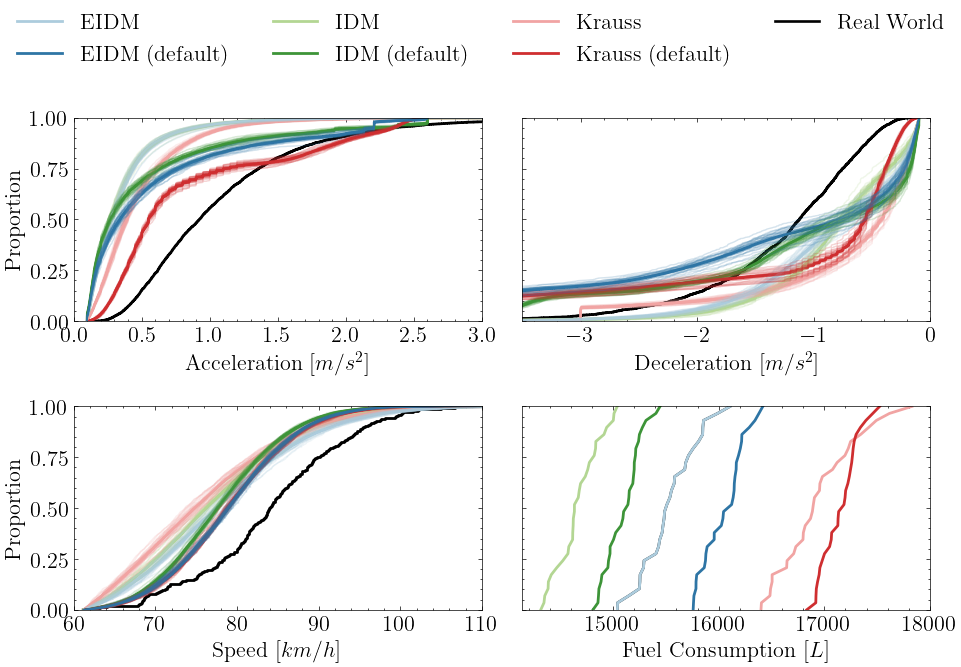

In [80]:
import matplotlib.pyplot as plt
import scienceplots
import seaborn as sns
import numpy as np
import matplotlib.patches as mpatches
from matplotlib.legend import _get_legend_handles_labels


color_map = {}
models = list(east_thru_df["carFollowingModel"].unique()) + ["Real World"]
# sort the models alphabetically
models.sort()
for i, model in enumerate(models):
    color_map[model] = colors[i]
    if model == "Real World":
        color_map[model] = "black"


# plotting acceleration with r2 > 0.9
create_ecdf(
    ax[0, 0],
    color_map,
    "accel",
    0.9,
    (0, 3),
    "slope",
    "Acceleration [$m/s^2$]",
    show_legend=False,
)
# # plotting deceleration with r2 > 0.9
create_ecdf(
    ax[0, 1], color_map, "decel", 0.9, (-3.5, 0), "slope", "Deceleration [$m/s^2$]"
)
# plot the speed with r2 > 0.9
create_ecdf(ax[1, 0], color_map, "cruise", 0.9, (60, 110), "speed", "Speed [$km/h$]")

# add in the fuel consumption histogram
sns.lineplot(
    x=np.sort(fuel_df[fuel_df["carFollowModel"] == models[0]]["fuel"].values),
    y=np.linspace(
        0, 1, len(fuel_df[fuel_df["carFollowModel"] == models[0]]["fuel"].values)
    ),
    ax=ax[1, 1],
    color=color_map["Real World"],
    alpha=1,
    linewidth=1.9,
    label="Real World",
)

for model in models:
    if model == "Real World":
        continue

    data = fuel_df[fuel_df["carFollowModel"] == model]["fuel"].values
    sns.lineplot(
        x=np.sort(data),
        y=np.linspace(0, 1, len(data)),
        ax=ax[1, 1],
        color=color_map[model],
        alpha=1,
        linewidth=2,
        label=model,
    )

ax[1, 1].set_xlabel("Fuel Consumption [$L$]")
h, l = ax[1, 1].get_legend_handles_labels()
# switch the first and last legend
h = h[1:] + [h[0]]
l = l[1:] + [l[0]]
fig.legend(h, l, loc="lower center", ncol=4, bbox_to_anchor=(0.5, 1))
# remove the legend from 1,1
ax[1, 1].legend_.remove()


### Create a Latex table of the mean and median values for each model


In [ ]:
table = create_table(
    0.9,
)


(0.0, 3.5)

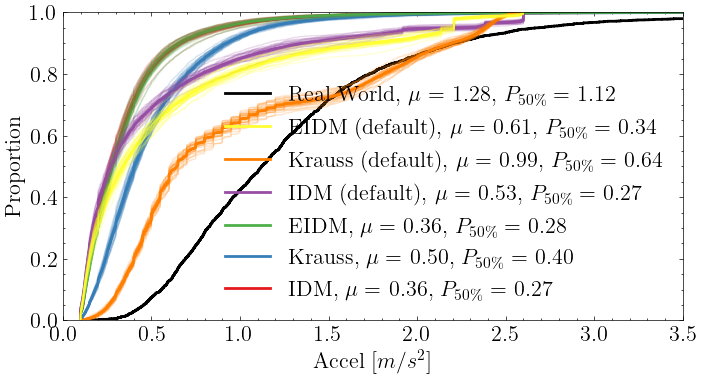

In [163]:
import matplotlib.pyplot as plt
import scienceplots
import seaborn as sns
import numpy as np
import matplotlib.patches as mpatches

plt.style.use("science")

fig, ax = plt.subplots(figsize=(8, 4))
# make the text bigger
plt.rcParams.update({"font.size": 16})

# plotting acceleration with r2 > 0.9
accel_sumo_df = east_thru_df[
    (east_thru_df["r2"] > 0.95)
    & (east_thru_df["type"] == "accel")
    & (east_thru_df["minimum_time"] > 0)
]

# concatenate the rw data
accel_rw_df = rw_df[
    (rw_df["r2"] > 0.95) & (rw_df["type"] == "accel") & (rw_df["minimum_time"] > 0)
].copy()
accel_rw_df["carFollowingModel"] = "Real World"
plot_df = pd.concat([accel_sumo_df, accel_rw_df])

colors = sns.color_palette("Set1", n_colors=len(plot_df["carFollowingModel"].unique()))
colors[-1] = "black"


sns.ecdfplot(
    data=plot_df,
    x="slope",
    hue="carFollowingModel",
    ax=ax,
    palette=colors,
    linewidth=2,
    legend=True,
)

labels = []
for i, model in enumerate(plot_df["carFollowingModel"].unique()):
    labels += [model]
    if model == "Real World":
        continue
    for seed in plot_df[plot_df["carFollowingModel"] == model]["seed"].unique():
        # if the seed is the mean, plot it in black
        data = plot_df.loc[
            (plot_df["carFollowingModel"] == model) & (plot_df["seed"] == seed), "slope"
        ].values
        sns.lineplot(
            x=np.sort(data),
            y=np.linspace(0, 1, len(data)),
            ax=ax,
            color=colors[i],
            alpha=0.2,
            linewidth=1,
            legend=False,
        )

# sns.ecdfplot(data=plot_df, x="slope", hue="carFollowingModel", stat="proportion", ax=ax, )
# remove the carFollowingModel title from the legend
ax.legend_.set_title(None)

# set the legend to include the mean and median
labels = [
    f"{label}, $\mu = $ {plot_df[plot_df['carFollowingModel'] == label]['slope'].mean():.2f}, "
    + "$P_{50\%} = $ "
    + f"{plot_df[plot_df['carFollowingModel'] == label]['slope'].median():.2f}"
    for label in labels
][::-1]

ax.legend(labels=labels)


# set the x and y axis labels
ax.set_xlabel("Accel [$m/s^2$]")

# set the x and y axis limits
ax.set_xlim(0, 3.5)


KeyboardInterrupt: 

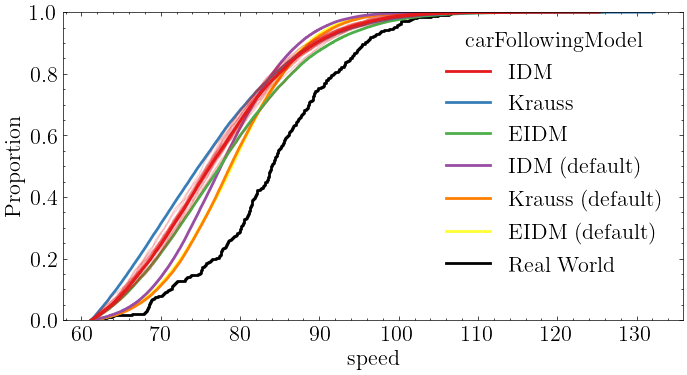

In [127]:
import matplotlib.pyplot as plt
import scienceplots
import seaborn as sns
import numpy as np
import matplotlib.patches as mpatches

plt.style.use("science")

fig, ax = plt.subplots(figsize=(8, 4))
# make the text bigger
plt.rcParams.update({"font.size": 16})

# plotting acceleration with r2 > 0.9
accel_sumo_df = east_thru_df[
    (east_thru_df["rmse"] < 0.05)
    & (east_thru_df["type"] == "cruise")
    & (east_thru_df["speed"] > 17)
]

# concatenate the rw data
accel_rw_df = rw_df[
    (rw_df["rmse"] < 0.05) & (rw_df["type"] == "cruise") & (rw_df["speed"] > 17)
].copy()

accel_rw_df["carFollowingModel"] = "Real World"
plot_df = pd.concat([accel_sumo_df, accel_rw_df])
plot_df["speed"] = plot_df["speed"] * 3.6


colors = sns.color_palette("Set1", n_colors=len(plot_df["carFollowingModel"].unique()))
colors[-1] = "black"

sns.ecdfplot(
    data=plot_df,
    x="speed",
    hue="carFollowingModel",
    ax=ax,
    palette=colors,
    linewidth=2,
    legend=True,
)

labels = []
for i, model in enumerate(plot_df["carFollowingModel"].unique()):
    labels += [model]
    if model == "Real World":
        continue
    for seed in plot_df[plot_df["carFollowingModel"] == model]["seed"].unique():
        # if the seed is the mean, plot it in black
        data = plot_df.loc[
            (plot_df["carFollowingModel"] == model) & (plot_df["seed"] == seed), "speed"
        ].values
        sns.lineplot(
            x=np.sort(data),
            y=np.linspace(0, 1, len(data)),
            ax=ax,
            color=colors[i],
            alpha=0.2,
            linewidth=1,
            legend=False,
        )

# # sns.ecdfplot(data=plot_df, x="slope", hue="carFollowingModel", stat="proportion", ax=ax, )
# # remove the carFollowingModel title from the legend
# ax.legend_.set_title(None)

# # set the legend to include the mean and median
labels = [
    f"{label}, $\mu = $ {plot_df[plot_df['carFollowingModel'] == label]['speed'].mean():.2f}, "
    + "$P_{50\%} = $ "
    + f"{plot_df[plot_df['carFollowingModel'] == label]['speed'].median():.2f}"
    for label in labels
][::-1]

ax.legend(labels=labels)


# set the x and y axis labels
ax.set_xlabel("Speed [km/h]")


# set the x and y axis limits
ax.set_xlim(55, 120)


In [82]:
cruise_df["speed"].describe()


count    44.000000
mean     48.194663
std       7.517375
min      33.931664
25%      42.682669
50%      48.640121
75%      53.562594
max      62.983520
Name: speed, dtype: float64

In [68]:
slow_down_vehicles = rw_df.groupby("vehicle_id")["type"].apply(
    lambda x: any(x.str.contains("decel"))
)


In [69]:
slow_down_vehicles.sum() / slow_down_vehicles.shape[0]


0.8923151047940255

In [70]:
keep_vehicles = slow_down_vehicles[slow_down_vehicles == False].index


array([[<AxesSubplot: title={'center': 'speed'}>]], dtype=object)

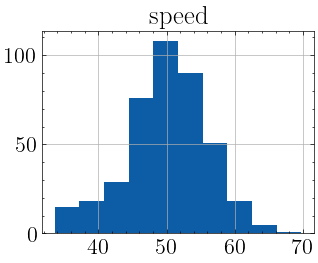

In [71]:
cruise_df.loc[cruise_df.vehicle_id.isin(keep_vehicles)].hist(
    column="speed",
)
